<a target="_blank" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/070_correlation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

(associations-notebook)=
# Le relazioni tra variabili

In questo capitolo, ci addentreremo nel complesso mondo della correlazione e della causalità, due concetti che, benché strettamente connessi, rimangono distinti nell'analisi dei dati. La correlazione misura la forza e la direzione dell'associazione lineare tra due variabili, ma non implica necessariamente una relazione causale tra di esse. Esploreremo come la correlazione possa manifestarsi in diverse strutture causali quali il Fork, il Pipe, il Collider e i Descendents, evidenziando come possa risultare talvolta ingannevole. Comprendere questi aspetti è fondamentale per interpretare correttamente i dati ed evitare errori comuni, come la confusione tra correlazione e causalità. Attraverso l'analisi di indici statistici come la covarianza e l'esplorazione dell'effetto dei confounders, ci avventureremo oltre la mera analisi bivariata, sondando le complesse dinamiche che guidano le relazioni tra le variabili.

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import graphviz

In [4]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
sns.set_palette("colorblind")

(sec-zetsche-scatter)=
## Diagramma a dispersione

Il diagramma a dispersione è un grafico che rappresenta le coppie di punti individuate da due variabili, solitamente rappresentate sull'asse delle ascisse e sulle ordinate. Un esempio concreto di utilizzo del diagramma a dispersione si trova nella ricerca condotta da Zetsche et al. (2019), in cui i ricercatori hanno utilizzato due scale psicometriche, il Beck Depression Inventory II (BDI-II) e la Center for Epidemiologic Studies Depression Scale (CES-D), per misurare il livello di depressione dei soggetti. l BDI-II è uno strumento self-report che valutare la presenza e l'intensità di sintomi depressivi in pazienti adulti e adolescenti di almeno 13 anni di età con diagnosi psichiatrica mentre la CES-D è una scala self-report progettata per misurare i sintomi depressivi che sono stati vissuti nella settimana precedente nella popolazione generale, specialmente quella degli adolescenti/giovani adulti. Ponendo i valori BDI-II sull'asse delle ascisse e quelli del CES-D sull'asse delle ordinate, ogni punto sul grafico rappresenta un individuo del quale si conosce il livello di depressione misurato dalle due scale.

È evidente che i valori delle scale BDI-II e CES-D non possono essere gli stessi per due ragioni: (1) la presenza degli errori di misurazione e (2) l'uso di unità di misura arbitrarie per le due variabili. L'errore di misurazione è un fattore che compromette sempre, almeno in parte, qualsiasi misurazione, ed è particolarmente rilevante in psicologia dove la precisione degli strumenti di misurazione è generalmente inferiore rispetto ad altre discipline, come la fisica. Il secondo motivo per cui i valori delle scale BDI-II e CES-D non possono essere uguali è che l'unità di misura della depressione è una questione arbitraria e non standardizzata. Tuttavia, nonostante le differenze derivanti dall'errore di misurazione e dall'uso di unità di misura diverse, ci si aspetta che, se le due scale misurano lo stesso costrutto (la depressione), i valori prodotti dalle due scale dovrebbero essere linearmente associati tra di loro. Per comprendere meglio il concetto di "associazione lineare", è possibile esaminare i dati attraverso l'utilizzo di un diagramma a dispersione.

Leggiamo i dati di {ref}`sec-zetsche-scatter`. 

In [3]:
df = pd.read_csv("../data/data.mood.csv", index_col=0)
df = df[["esm_id", "group", "bdi", "cesd_sum"]]
df = df.drop_duplicates(keep="first")
df = df[pd.notnull(df["bdi"])]

Consideriamo la relazione tra i punteggi BDI-II e CESD.

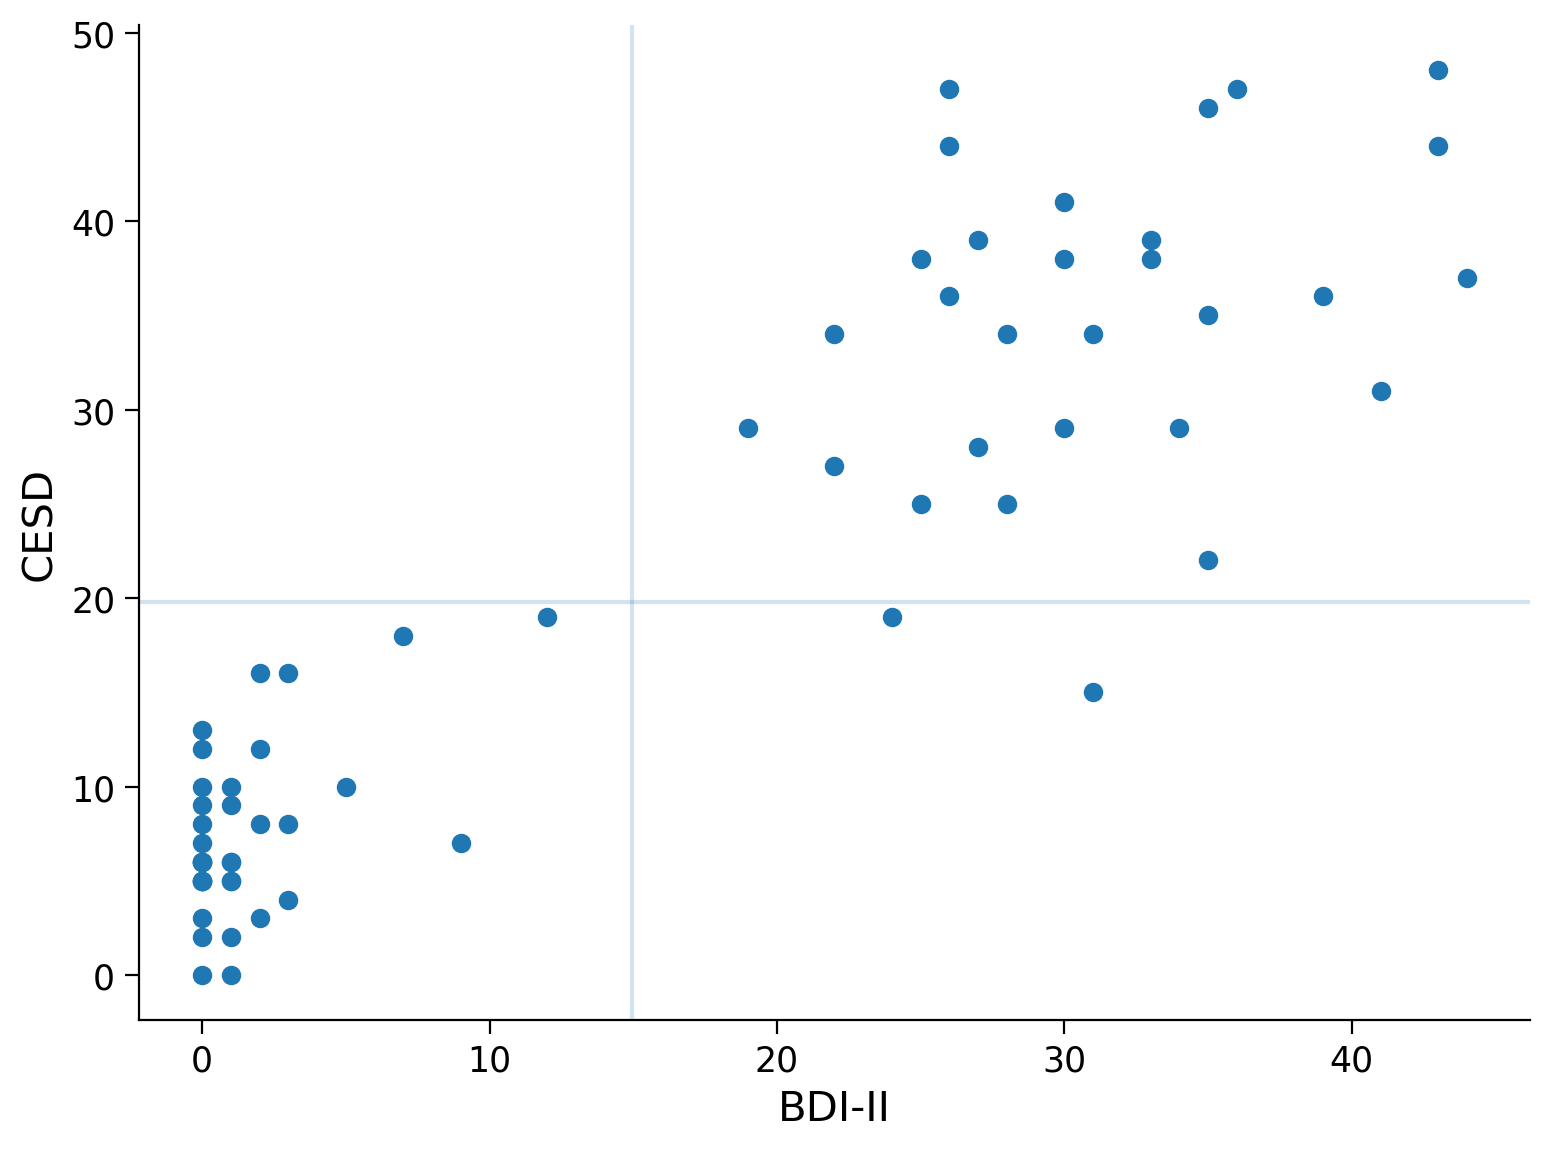

In [4]:
plt.scatter(df["bdi"], df["cesd_sum"])
plt.rcParams.update({"figure.figsize": (10, 10), "figure.dpi": 100})
plt.xlabel("BDI-II")
plt.ylabel("CESD")
plt.axvline(np.mean(df.bdi), alpha=0.2)
plt.axhline(np.mean(df.cesd_sum), alpha=0.2);

Dall'osservazione del diagramma a dispersione, possiamo notare che i dati mostrano una tendenza a distribuirsi intorno ad una retta. In termini statistici, ciò significa che i punteggi CES-D e BDI-II sono linearmente associati. Tuttavia, la relazione lineare tra le due variabili è lontana dall'essere perfetta, poiché se fosse perfetta, tutti i punti nel diagramma sarebbero allineati perfettamente lungo una retta. Pertanto, sorge la necessità di trovare un indice numerico che descriva la forza e la direzione della relazione lineare tra le due variabili e che misuri la deviazione della nube di punti da una relazione lineare perfetta. Ci sono diversi indici statistici disponibili per questo scopo.

## Covarianza

Iniziamo a considerare il più importante di tali indici, chiamato *covarianza*. In realtà la definizione di questo indice non ci sorprenderà più di tanto in quanto, in una forma solo apparentemente diversa, l'abbiamo già incontrata in precedenza. Ci ricordiamo infatti che la varianza di una generica variabile $X$ è definita come la media degli scarti quadratici di ciascuna osservazione dalla media:

$$
S_{XX} = \frac{1}{n} \sum_{i=1}^n(X_i - \bar{X}) (X_i - \bar{X}). 
$$

La varianza viene talvolta descritta come la "covarianza di una variabile con sé stessa". Adesso facciamo un passo ulteriore. Invece di valutare la dispersione di una sola variabile, ci chiediamo come due variabili $X$ e $Y$ "variano insieme" (co-variano). È facile capire come una risposta a tale domanda possa essere fornita da una semplice trasformazione della formula precedente che diventa:

$$
S_{XY} = \frac{1}{n} \sum_{i=1}^n(X_i - \bar{X}) (Y_i - \bar{Y}).
$$ (eq-cov-def)

L'eq. {eq}`eq-cov-def` ci fornisce la definizione della covarianza.

### Interpretazione

Per capire il significato dell'eq. {eq}`eq-cov-def`, supponiamo di dividere il grafico riportato nella sezione {ref}`sec-zetsche-scatter` in quattro quadranti definiti da una retta verticale passante per la media dei valori BDI-II e da una retta orizzontale passante per la media dei valori CES-D. Numeriamo i quadranti partendo da quello in basso a sinistra e muovendoci in senso antiorario.

Se prevalgono punti nel I e III quadrante, allora la nuvola di punti avrà un andamento crescente (per cui a valori bassi di $X$ tendono ad associarsi valori bassi di $Y$ e a valori elevati di $X$ tendono ad associarsi valori elevati di $Y$) e la covarianza avrà segno positivo. Mentre se prevalgono punti nel II e IV quadrante la nuvola di punti avrà un andamento decrescente (per cui a valori bassi di $X$ tendono ad associarsi valori elevati di $Y$ e a valori elevati di $X$ tendono ad associarsi valori bassi di $Y$) e la covarianza avrà segno negativo. Dunque, il segno della covarianza ci informa sulla direzione della relazione lineare tra due variabili: l'associazione lineare si dice positiva se la covarianza è positiva, negativa se la covarianza è negativa.

**Esercizio.** Implemento la {eq}`eq-cov-def` in Python.

In [5]:
def cov_value(x, y):

    mean_x = sum(x) / float(len(x))
    mean_y = sum(y) / float(len(y))

    sub_x = [i - mean_x for i in x]
    sub_y = [i - mean_y for i in y]

    sum_value = sum([sub_y[i] * sub_x[i] for i in range(len(x))])
    denom = float(len(x))

    cov = sum_value / denom
    return cov

Per i dati mostrati nel diagramma, la covarianza tra BDI-II e CESD è 207.4

In [6]:
x = df["bdi"]
y = df["cesd_sum"]

cov_value(x, y)

207.42653810835637

Oppure, in maniera più semplice:

In [7]:
np.mean((x - np.mean(x)) * (y - np.mean(y)))

207.42653810835628

Lo stesso risultato si ottiene con la funzione `cov` di NumPy.

In [8]:
np.cov(x, y, ddof=0)

array([[236.23875115, 207.42653811],
       [207.42653811, 222.83379247]])

## Correlazione

La direzione della relazione tra le variabili è indicata dal segno della covarianza, ma il valore assoluto di questo indice non fornisce informazioni utili poiché dipende dall'unità di misura delle variabili. Ad esempio, considerando l'altezza e il peso delle persone, la covarianza sarà più grande se l'altezza è misurata in millimetri e il peso in grammi, rispetto al caso in cui l'altezza è in metri e il peso in chilogrammi. Pertanto, per descrivere la forza e la direzione della relazione lineare tra due variabili in modo adimensionale, si utilizza l'indice di correlazione.

La correlazione è ottenuta standardizzando la covarianza tramite la divisione delle deviazioni standard ($s_X$, $s_Y$) delle due variabili:

$$ 
r_{XY} = \frac{S_{XY}}{S_X S_Y}. 
$$ (eq-cor-def)

La quantità che si ottiene in questo modo viene chiamata *correlazione* di Bravais-Pearson (dal nome degli autori che, indipendentemente l'uno dall'altro, l'hanno introdotta).

### Proprietà

Il coefficiente di correlazione ha le seguenti proprietà:

-   ha lo stesso segno della covarianza, dato che si ottiene dividendo la covarianza per due numeri positivi;
-   è un numero puro, cioè non dipende dall'unità di misura delle variabili;
-   assume valori compresi tra -1 e +1.

### Interpretazione  

All'indice di correlazione possiamo assegnare la seguente interpretazione:

1.  $r_{XY} = -1$ $\rightarrow$ perfetta relazione negativa: tutti i punti si trovano esattamente su una retta con pendenza negativa (dal quadrante in alto a sinistra al quadrante in basso a destra);
2.  $r_{XY} = +1$ $\rightarrow$ perfetta relazione positiva: tutti i punti si trovano esattamente su una retta con pendenza positiva (dal quadrante in basso a sinistra al quadrante in alto a destra);
3.  $-1 < r_{XY} < +1$ $\rightarrow$ presenza di una relazione lineare di intensità diversa;
4.  $r_{XY} = 0$ $\rightarrow$ assenza di relazione lineare tra $X$ e $Y$.

**Esercizio.** Per i dati riportati nel diagramma della sezione {ref}`sec-zetsche-scatter`, la covarianza è 207.4. Il segno positivo della covarianza ci dice che tra le due variabili c'è un'associazione lineare positiva. Per capire quale sia l'intensità della relazione lineare calcoliamo la correlazione. Essendo le deviazioni standard del BDI-II e del CES-D rispettavamente uguali a 15.37 e 14.93, la correlazione diventa uguale a $\frac{207.426}{15.38 \cdot 14.93} = 0.904.$ Tale valore è prossimo a 1.0, il che vuol dire che i punti del diagramma a dispersione non si discostano troppo da una retta con una pendenza positiva.

Troviamo la correlazione con la funzione `corrcoef()`:

In [9]:
np.corrcoef(x, y)

array([[1.        , 0.90406202],
       [0.90406202, 1.        ]])

Replichiamo il risultato implementando l'eq. {eq}`eq-cor-def`: 

In [18]:
s_xy = np.mean((x - np.mean(x)) * (y - np.mean(y)))
s_x = x.std(ddof=0)
s_y = y.std(ddof=0)
r_xy = s_xy / (s_x * s_y)
print(r_xy)

0.9040620189474861


Un altro modo ancora per trovare la correlazione tra i punteggi BDI-II e CESD è quello di standardizzare le due variabili per poi applicare la formula della covarianza:

In [10]:
z_x = (x - np.mean(x)) / np.std(x, ddof=0)
z_y = (y - np.mean(y)) / np.std(y, ddof=0)
np.mean(z_x * z_y)

0.9040620189474862

## Correlazione e causazione

È fondamentale ricordare che la correlazione rappresenta solo un indice descrittivo della relazione lineare tra due variabili e *non può in alcun modo* essere utilizzata per trarre conclusioni sulle relazioni *causali* tra le variabili. L'espressione ben nota "correlazione non implica causalità" sottolinea questo concetto importante. Un esempio illustrativo delle correlazioni spurie può essere trovato sul sito [spurious correlations](https://tylervigen.com/spurious-correlations).

### Confounding

Il seguente semplice esempio aiuta a chiarire che la correlazione non può informarci sulle relazioni causali.

Supponiamo che `b` rappresenti una variabile di confondimento.


In [12]:
b = np.random.rand(100)

Nella simulazione, le variabili `a` e `c` sono indipendenti tra di loro dal punto di vista causale, ma entrambe sono influenzate dalla variabile `b`. Come vedremo in seguito, questa struttura casuale si chiama Fork.

In [13]:
a = b + .1 * np.random.rand(100)
c = b + .3 * np.random.rand(100)

Esaminiamo ora la correlazione tra `a` e `c`.

In [14]:
coef, p_val = stats.pearsonr(a, c)
print(coef)

0.9419559051487212


In altre parole, anche se le variabili `a` e `c`  sono causalmente indipendenti, la presenza di una terza variabile `b` (variabile di confondimento) che le influenza entrambe fa sì che `a` e `c` siano correlate tra di loro.

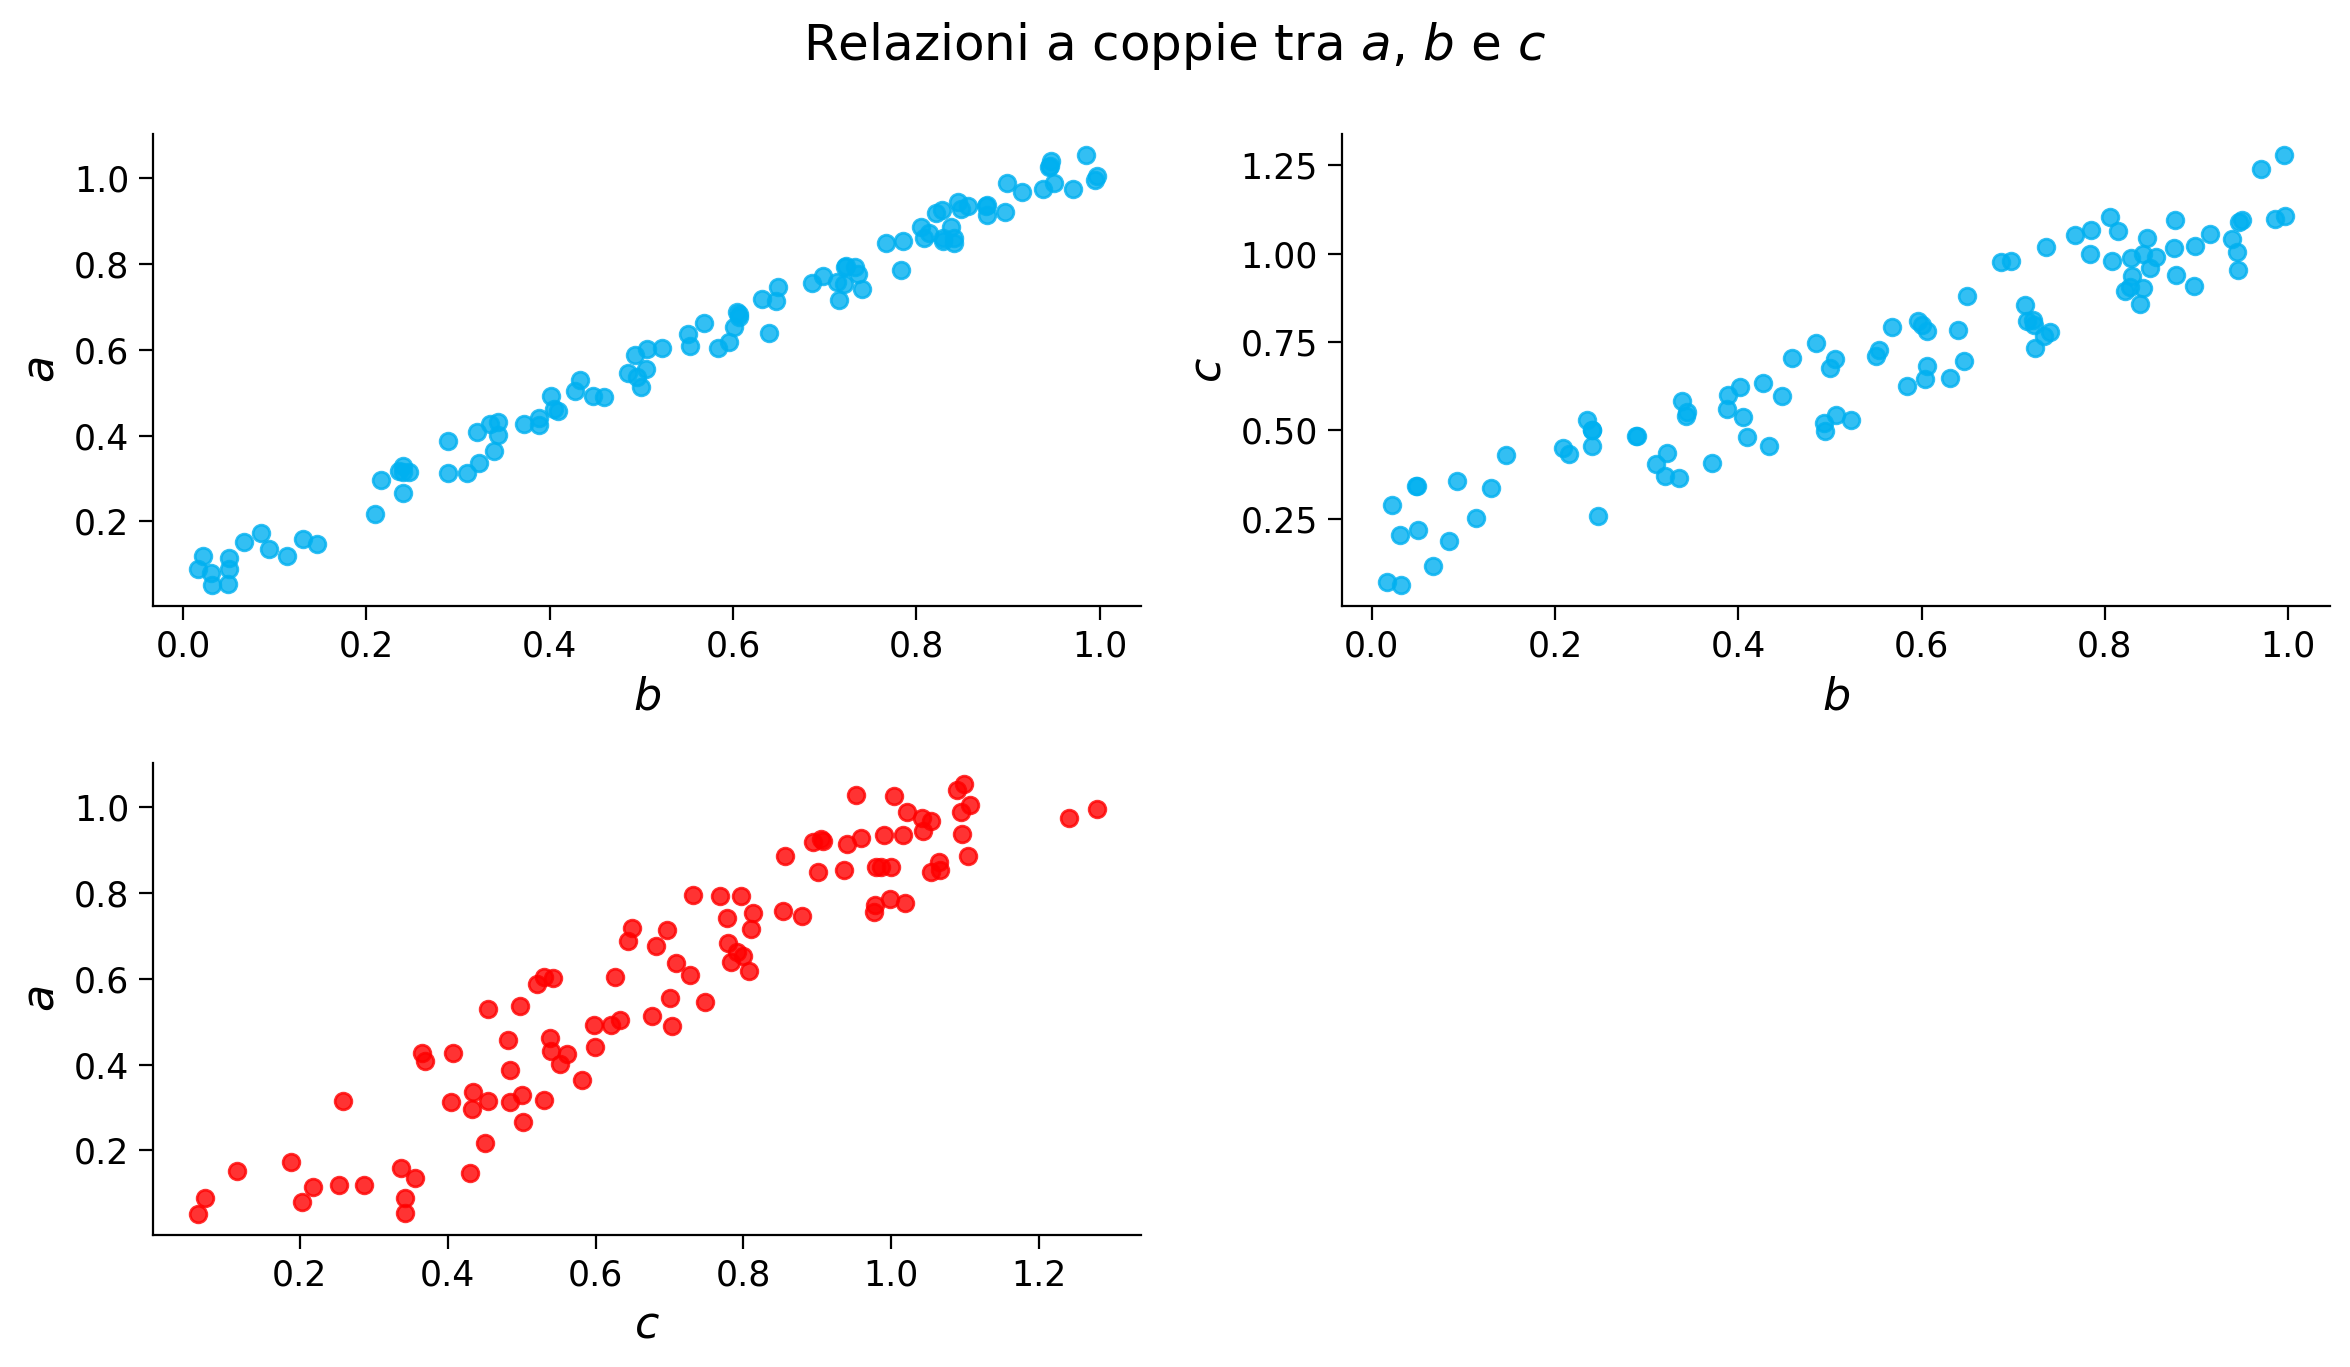

In [15]:
# Il codice è tratto da A. Molak (2023) "Causal Inference and Discovery in Python".

COLORS = ["#00B0F0", "#FF0000"]

variables = {"a": a, "b": b, "c": c}

for i, (var_1, var_2) in enumerate([("b", "a"), ("b", "c"), ("c", "a")]):
    color = COLORS[1]

    if "b" in [var_1, var_2]:
        color = COLORS[0]

    plt.subplot(2, 2, i + 1)
    plt.scatter(variables[var_1], variables[var_2], alpha=0.8, color=color)

    plt.xlabel(f"${var_1}$", fontsize=16)
    plt.ylabel(f"${var_2}$", fontsize=16)

plt.suptitle("Relazioni a coppie tra $a$, $b$ e $c$")
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()

## Usi della correlazione

Pur non essendo adatta per stabilire relazioni causali, la correlazione trova ampio utilizzo nel contesto psicometrico, ad esempio nella valutazione della *validità concorrente* di un test psicologico. Se un test psicologico misura in modo accurato ciò che si prefigge di misurare (come ad esempio la depressione nel caso specifico), ci aspettiamo che esso mostri una forte correlazione con i risultati di altri test che misurano lo stesso costrutto, come evidenziato dai dati di {cite:t}`zetsche_2019future`. Un'altra proprietà importante di un test psicometrico è la *validità divergente*, ossia la mancanza di associazione tra i risultati di test che misurano costrutti diversi. Pertanto, in tale contesto, ci aspettiamo una bassa correlazione tra i risultati di test che misurano costrutti differenti.

## Correlazione di Spearman

Un'alternativa per valutare la relazione lineare tra due variabili è il coefficiente di correlazione di Spearman, che si basa esclusivamente sull'ordine dei dati e non sugli specifici valori. Questo indice di associazione è particolarmente adatto quando gli psicologi sono in grado di misurare solo le relazioni di ordine tra diverse modalità di risposta dei soggetti, ma non l'intensità della risposta stessa. Tali variabili psicologiche che presentano questa caratteristica sono definite come "ordinali".

```{admonition} Nota
È importante ricordare che, nel caso di una variabile ordinale, non è possibile utilizzare le statistiche descrittive convenzionali come la media e la varianza per sintetizzare le osservazioni. Tuttavia, è possibile riassumere le osservazioni attraverso una distribuzione di frequenze delle diverse modalità di risposta. Come abbiamo appena visto, la direzione e l'intensità dell'associazione tra due variabili ordinali possono essere descritte utilizzando il coefficiente di correlazione di Spearman.
```

Per fornire un esempio, consideriamo due variabili di scala ordinale e calcoliamo la correlazione di Spearman tra di esse.

In [16]:
stats.spearmanr([1, 2, 3, 4, 5], [5, 6, 7, 8, 7])

SignificanceResult(statistic=0.8207826816681233, pvalue=0.08858700531354381)

## Correlazione nulla

Un aspetto finale da sottolineare riguardo alla correlazione è che essa descrive la direzione e l'intensità della *relazione lineare* tra due variabili. Tuttavia, la correlazione non cattura relazioni non lineari tra le variabili, anche se possono essere molto forti. È fondamentale comprendere che una correlazione pari a zero non implica l'assenza di una relazione tra le due variabili, ma indica solamente l'assenza di una relazione lineare tra di esse.

La figura seguente fornisce tredici esempi di correlazione nulla in presenza di una chiara relazione (non lineare) tra due variabili. In questi tredici insiemi di dati i coefficienti di correlazione di Pearson sono sempre uguali a 0. Ma questo non significa che non vi sia alcuna relazione tra le variabili.

In [18]:
datasaurus_data = pd.read_csv("../data/datasaurus.csv")
datasaurus_data.groupby("dataset").agg(
    {"x": ["count", "mean", "std"], "y": ["count", "mean", "std"]}
)

x                           y                      
           count       mean        std count       mean        std
dataset                                                           
away         142  54.266100  16.769825   142  47.834721  26.939743
bullseye     142  54.268730  16.769239   142  47.830823  26.935727
circle       142  54.267320  16.760013   142  47.837717  26.930036
dino         142  54.263273  16.765142   142  47.832253  26.935403
dots         142  54.260303  16.767735   142  47.839829  26.930192
h_lines      142  54.261442  16.765898   142  47.830252  26.939876
high_lines   142  54.268805  16.766704   142  47.835450  26.939998
slant_down   142  54.267849  16.766759   142  47.835896  26.936105
slant_up     142  54.265882  16.768853   142  47.831496  26.938608
star         142  54.267341  16.768959   142  47.839545  26.930275
v_lines      142  54.269927  16.769959   142  47.836988  26.937684
wide_lines   142  54.266916  16.770000   142  47.831602  26.937902
x_shape      142  54.260150  16.769958   142  47.839717  26.930002

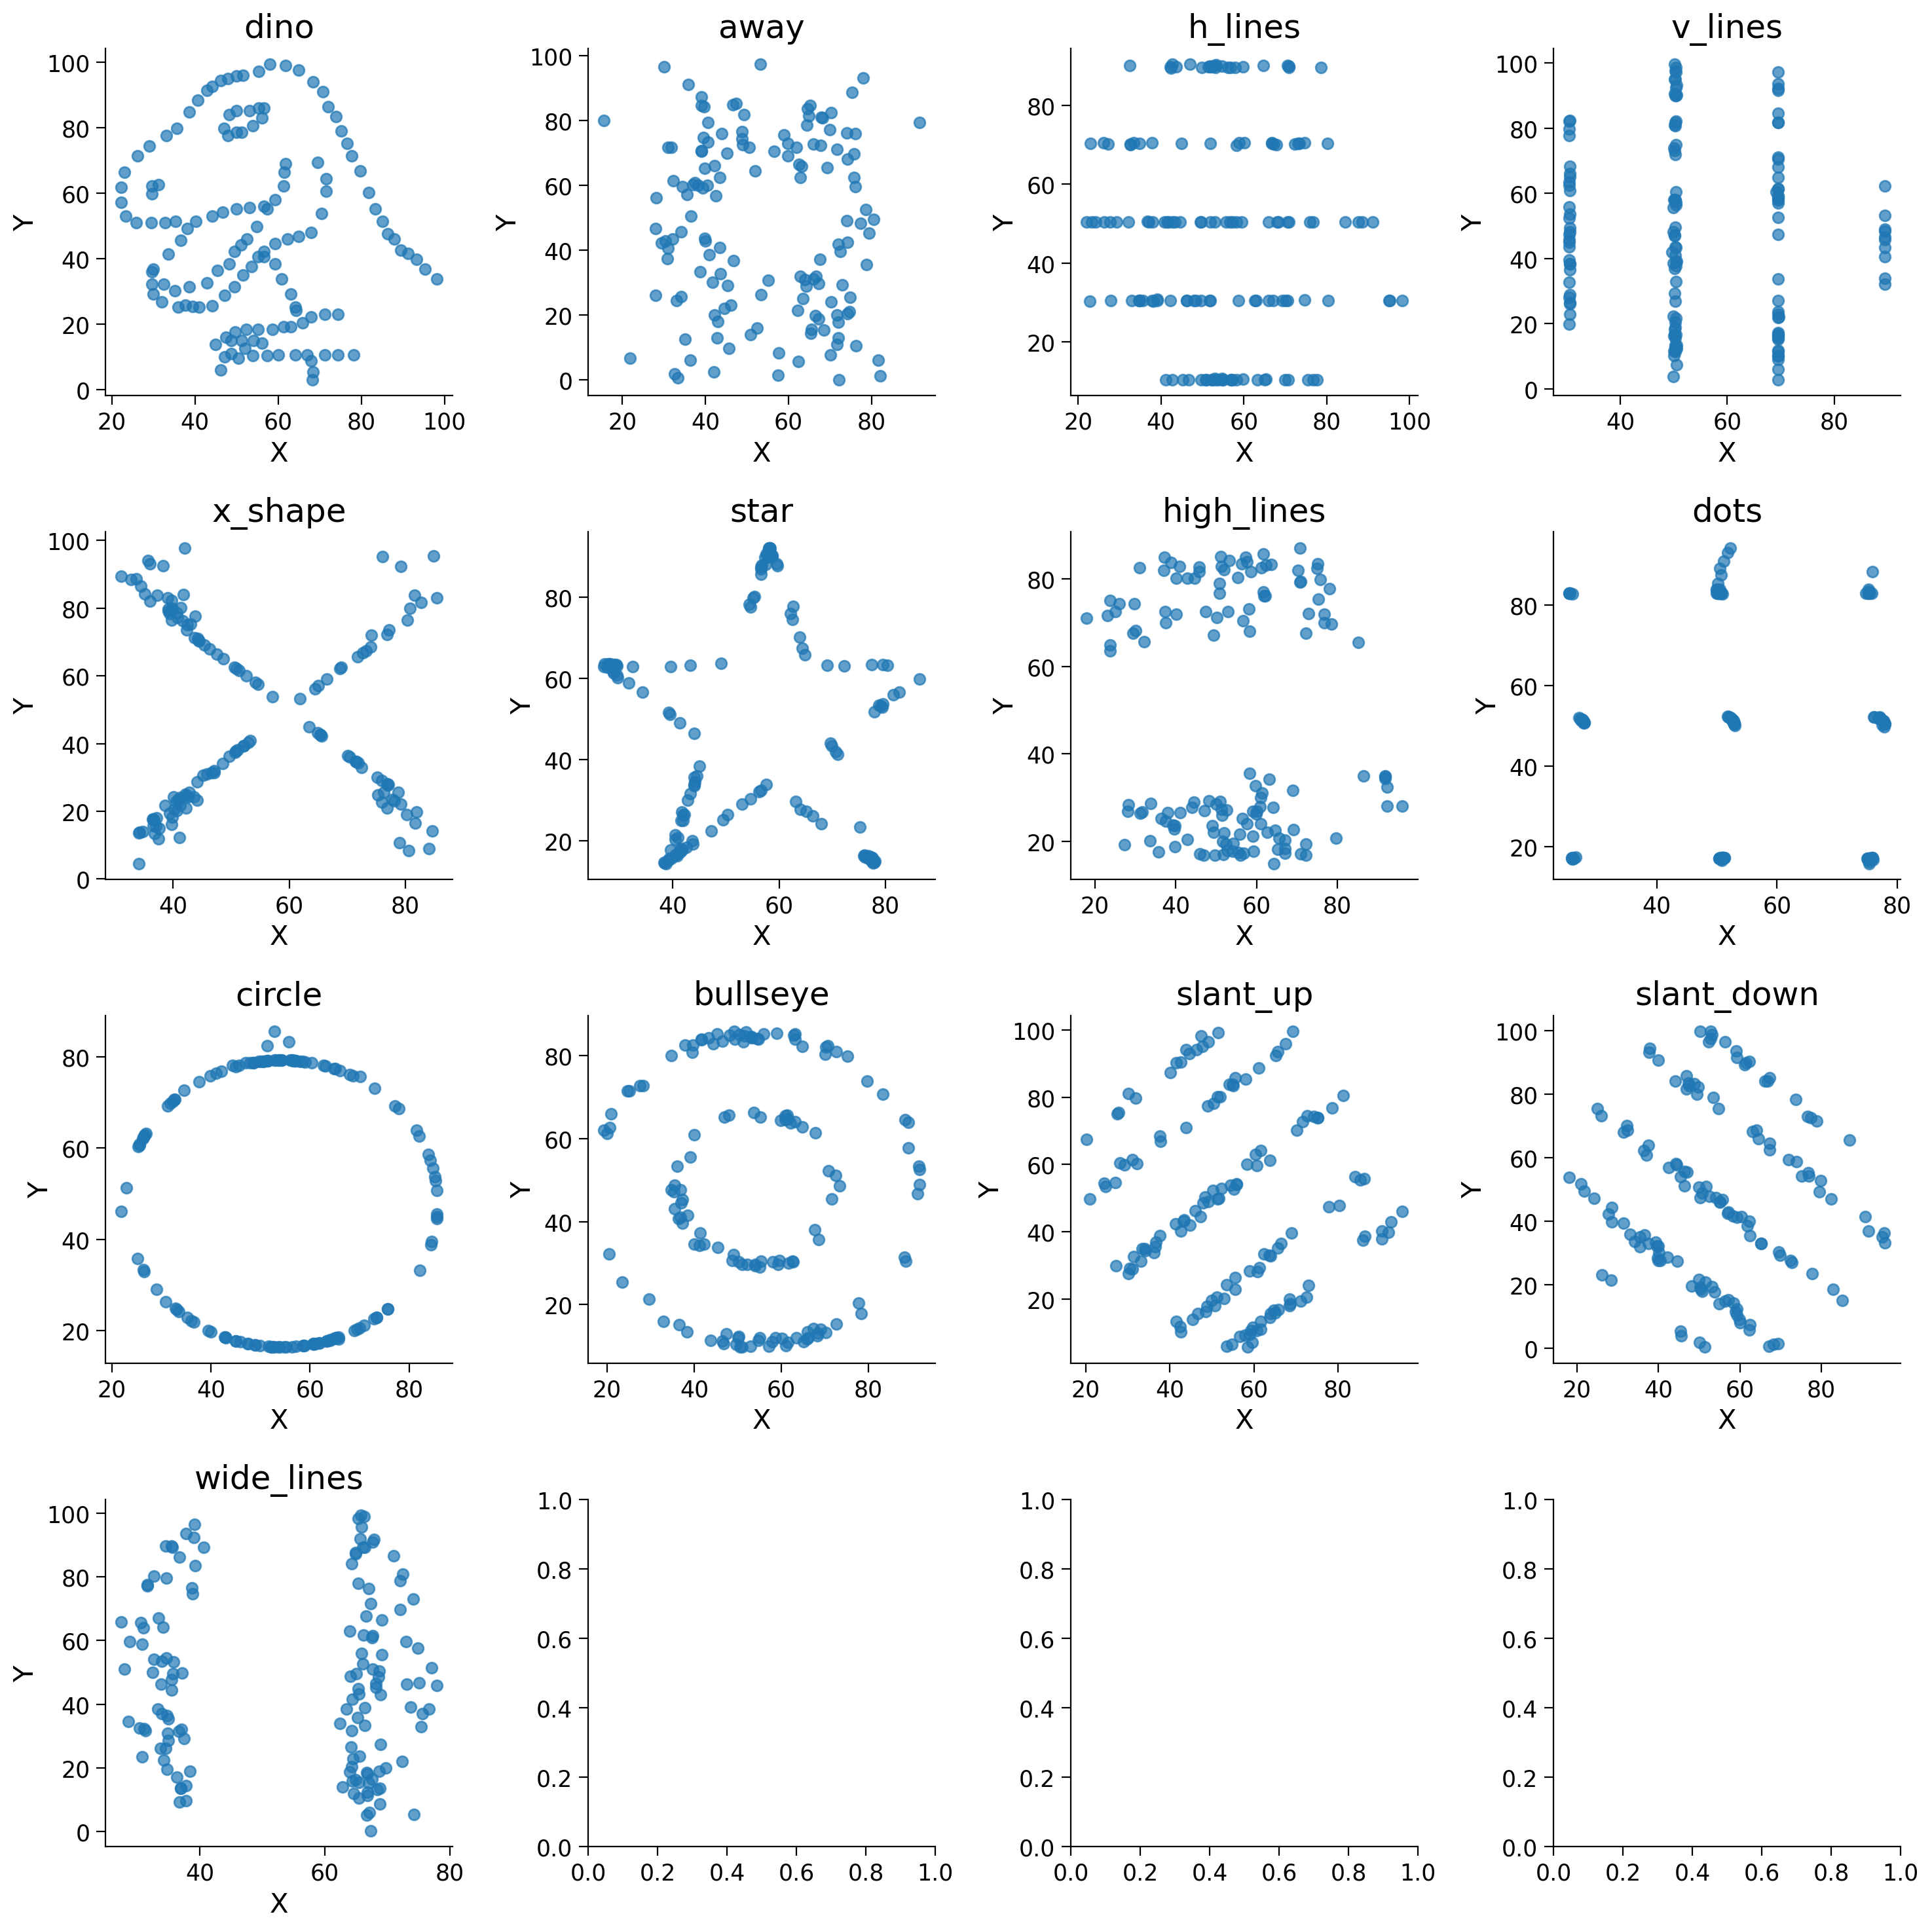

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
datasets = datasaurus_data["dataset"].unique()

for i, dataset in enumerate(datasets):
    row = i // 4
    col = i % 4
    ax = axs[row, col]
    subset = datasaurus_data[datasaurus_data["dataset"] == dataset]
    ax.scatter(subset["x"], subset["y"], alpha=0.7)
    ax.set_title(dataset)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

plt.tight_layout()
plt.show()

## Confounders fondamentali

Poniamoci ora il problema di esaminare come la correlazione si manifesta all'interno di diverse strutture causali, quali il Fork, il Pipe, il Collider e i Descendents. Analizzeremo la correlazione tra due variabili in questi diversi contesti mettendo in luce l'effetto che i confounders possono avere su di essa.

Nelle strutture causali menzionate, vedremo come la correlazione possa talvolta risultare ingannevole. Ad esempio, nel caso del Collider, la correlazione può emergere o scomparire a causa della stratificazione di una variabile che risente dell'influenza di entrambe le variabili di interesse. Allo stesso modo, i Descendents, cioè le variabili che sono influenzate da altre all'interno della catena causale, possono alterare la percezione delle relazioni tra le variabili.

Questi fenomeni sottolineano l'importanza di una comprensione accurata dei confounders, in particolare quelli fondamentali, che devono essere esaminati attentamente nell'analisi. In sintesi, la correlazione, benché sia uno strumento descrittivo potente, deve essere interpretata con cautela, specialmente quando si tratta di trarre deduzioni sulle complesse relazioni causali che possono celarsi dietro una semplice analisi bivariata.

### Biforcazione

In un diagramma causale, una biforcazione rappresenta una struttura specifica in cui una variabile comune causa due o più variabili figlie. Ad esempio, se abbiamo una variabile $Z$ che causa sia $X$ che $Y$, questo può essere rappresentato come una biforcazione nella struttura del diagramma. La biforcazione può essere un punto cruciale nell'analisi, poiché la comprensione delle relazioni tra le variabili a questo punto può aiutare a discernere le vere relazioni causali.

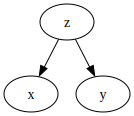

In [13]:
f = graphviz.Digraph()
f.edge("z", "x")
f.edge("z", "y")
f

Nell'analisi delle relazioni causali, può emergere una situazione in cui due variabili, $X$ e $Y$, sembrano essere associate. Questa associazione, tuttavia, potrebbe non essere una diretta relazione causale tra $X$ e $Y$, ma piuttosto un effetto di una terza variabile, $Z$, che è una "causa comune" per entrambe.

La presenza di $Z$ come causa comune significa che influisce su $X$ e $Y$, e quindi può creare o mascherare una relazione apparente tra di loro. L'associazione osservata tra $X$ e $Y$ è quindi spiegata dalla presenza di $Z$, che influisce su entrambe le variabili e crea una connessione tra di loro, anche se non esiste una relazione causale diretta.

Quando si riconosce la presenza di questa causa comune e si stratifica l'analisi per $Z$ (cioè si divide l'analisi in gruppi o strati in base ai livelli di $Z$), l'associazione apparente tra $X$ e $Y$ scompare. Questo mostra che non c'è una relazione causale diretta tra $X$ e $Y$, ma che l'associazione era dovuta all'influenza comune di $Z$ su entrambe le variabili.

In sintesi, la situazione descritta evidenzia l'importanza di considerare attentamente le cause comuni quando si cercano relazioni causali nei dati. L'associazione apparente tra due variabili può essere spiegata o influenzata da una terza variabile, e l'analisi accurata di questa terza variabile può rivelare che le prime due non sono direttamente correlate tra loro.

### Pipe

Nel contesto delle relazioni causali, la struttura definita come "pipe" descrive una situazione in cui due variabili, $X$ e $Y$, sono associate tra loro attraverso l'influenza di una terza variabile, $Z$. Questa struttura può essere paragonata a un tubo in cui l'acqua (l'influenza di $X$ su $Y$) scorre dall'inizio alla fine, mediata dalla presenza del tubo stesso ($Z$).

In un tale sistema, $X$ e $Y$ appaiono come se fossero correlati, ma la correlazione è in realtà un artefatto della relazione tra $X$ e $Z$, e $Z$ e $Y$. Ogni cambiamento in $X$ può indurre un cambiamento in $Y$, ma questo avviene solo attraverso il suo effetto su $Z$. L'associazione tra $X$ e $Y$ è, quindi, come un segnale che passa attraverso $Z$.

Questa relazione può diventare particolarmente intricata quando si tenta di quantificare l'effetto diretto di $X$ su $Y$ in un modello statistico come la regressione. Supponiamo, per esempio, di avere il seguente modello di regressione:

$$ Y = \beta_0 + \beta_1 X + \beta_2 Z + \epsilon, $$

dove $ \epsilon $ è l'errore standard.

Includendo $Z$ nel modello come variabile di controllo, potremmo pensare di isolare l'effetto puro di $X$ su $Y$. Tuttavia, poiché $Z$ è influenzata da $X$ (è una conseguenza del trattamento), includerla significherebbe che stiamo parzialmente eliminando l'effetto che vogliamo stimare. In altre parole, stiamo cercando di misurare l'effetto di $X$ su $Y$ che non passa attraverso $Z$, ma questo è proprio l'effetto che ci interessa!

Questo può portare a un "post-treatment bias," un errore che si verifica quando si controlla una variabile che è stata influenzata dal trattamento. Così facendo, si elimina parte dell'effetto causale che si vuole osservare, alterando la stima dell'effetto vero di $X$ su $Y$.

La struttura "pipe" evidenzia, quindi, come una comprensione profonda delle relazioni causali sia essenziale nello sviluppo di modelli statistici. Ignorare la natura mediata della relazione tra $X$ e $Y$ potrebbe portare a conclusioni errate riguardo all'effetto diretto di $X$ su $Y$, sottolineando l'importanza di una riflessione attenta e metodologica nella scelta delle variabili da includere o escludere in un modello.

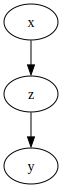

In [6]:
p = graphviz.Digraph()
p.edge('x','z')
p.edge('z','y')
p

### Collider

Nel campo delle relazioni causali, un collider è un particolare tipo di struttura in cui due variabili, diciamo $X$ e $Y$, influenzano una terza variabile, $Z$, ma non condividono cause comuni. In altre parole, $X$ e $Y$ non sono associate tra loro, ma entrambe hanno un effetto su $Z$.

Questa struttura può portare a situazioni complesse quando si tenta di analizzare le relazioni tra $X$ e $Y$. Ad esempio, se si stratifica il modello per $Z$, cioè se si prende in considerazione $Z$, può emergere un'associazione tra $X$ e $Y$ che in realtà non esiste nella popolazione. Questo fenomeno è noto come "bias del collider" e può sorgere da processi statistici o endogeni.

Immaginiano di voler studiare la relazione tra l'intelligenza ($X$) e la creatività ($Y$) di un gruppo di studenti. Inizialmente, non vi è alcuna relazione evidente tra queste due variabili: alcuni studenti sono molto intelligenti ma meno creativi, mentre altri sono molto creativi ma meno intelligenti. In altre parole, nella popolazione generale di studenti, non c'è nessuna associazione tra intelligenza e creatività.

Ora, immaginiamo che un prestigioso programma artistico selezioni gli studenti in base a una combinazione di intelligenza e creatività ($Z$). Per essere ammessi, gli studenti devono essere o estremamente intelligenti o estremamente creativi, o entrambi. Ma pochi studenti hanno valori elevate in entrambi gli aspetti.

Se analizzi solo gli studenti ammessi a questo programma (cioè, se condizioniamo i dati su $Z$), potremmo osservare una forte associazione negativa tra intelligenza e creatività. Questo accade perché la selezione nel programma funge da collider: gli studenti con intelligenza elevata tendono ad avere una creatività più bassa e viceversa, almeno tra quelli selezionati.

Questa associazione negativa è un artefatto della selezione e non riflette una relazione causale reale tra intelligenza e creatività. In effetti, tra gli studenti che non sono stati selezionati, non c'è alcuna associazione tra queste variabili. L'errore di condizionare su un collider (in questo caso, l'ammissione al programma) ha creato un'associazione "fantasma" tra intelligenza e creatività, che può portare a conclusioni errate se non si comprende la struttura sottostante delle relazioni causali.

Questo esempio evidenzia l'importanza di comprendere la struttura causale quando si analizzano le relazioni tra variabili, in particolare quando si utilizzano metodi statistici che possono essere sensibili a bias come quello del collider.

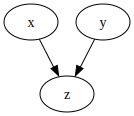

In [7]:
c = graphviz.Digraph()
c.edge('x','z')
c.edge('y','z')
c

### Il descendent

La nozione di "descendent" nelle relazioni causali può essere descritta attraverso una struttura gerarchica in cui una variabile influisce su un'altra, che a sua volta influisce su altre variabili. Nel diagramma dato, possiamo vedere che $X$ influisce su $Z$, e $Z$ influisce sia su $A$ che su $Y$. Qui, $A$ è un "descendent" di $Z$, e $Z$ è a sua volta un descendent di $X$.

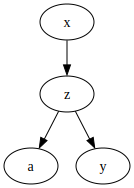

In [8]:
d = graphviz.Digraph()
d.edge('x','z')
d.edge('z','a')
d.edge('z','y')
d

Proviamo a spiegare questo concetto attraverso un esempio psicologico.

Immaginiamo un contesto lavorativo in cui stiamo esaminando tre aspetti chiave: l'istruzione di un individuo ($X$), le competenze sul lavoro ($Z$), e il successo professionale ($Y$). Inoltre, consideriamo la soddisfazione lavorativa ($A$) come un elemento che riflette le competenze sul lavoro.

1. **L'istruzione e le Competenze sul Lavoro**: Più elevata è l'istruzione di un individuo ($X$), migliori saranno le sue competenze sul lavoro ($Z$). Qui, l'istruzione è una causa diretta delle competenze sul lavoro.

2. **Le Competenze sul Lavoro e la Soddisfazione Lavorativa**: Le competenze sul lavoro ($Z$) non solo influenzano il successo professionale ($Y$) ma si riflettono anche nella soddisfazione lavorativa ($A$) dell'individuo.

3. **L'istruzione e il Successo Professionale**: L'istruzione ($X$) può portare al successo professionale ($Y$), ma questa relazione è mediata dalle competenze sul lavoro ($Z$). In altre parole, l'istruzione influisce sul successo lavorativo attraverso le competenze che essa genera.

Se vogliamo analizzare la relazione diretta tra l'istruzione e il successo professionale, dobbiamo essere cauti nell'includere la soddisfazione lavorativa ($A$) nel modello. Poiché $A$ è un "descendent" di $Z$, includerla significa includere indirettamente anche $Z$. In pratica, controllare per la soddisfazione lavorativa ci dà una visione parziale delle competenze sul lavoro, ma in un modo che potrebbe indebolire o alterare la nostra comprensione della relazione diretta tra l'istruzione e il successo professionale.

Questo concetto di "descendent" è estremamente importante in molti ambiti, come ad esempio le reti sociali, dove le connessioni tra individui possono creare catene di influenze indirette.

In conclusione, il concetto di "descendent" ci aiuta a comprendere come le relazioni causali possano essere complesse e interconnesse, richiedendo un'attenta considerazione nella modellazione e nell'analisi. La consapevolezza di come le variabili siano collegate in una struttura gerarchica può essere cruciale per una corretta interpretazione e per evitare conclusioni fuorvianti.

## Commenti e considerazioni finali

In questo capitolo, abbiamo esplorato il delicato legame tra correlazione e causalità, unendo il contesto dell'analisi descrittiva con modelli causalità più complessi come il "pipe", il "collider" e i "descendents". La correlazione ci offre un primo sguardo sulle relazioni tra variabili, ma come abbiamo visto, non sempre essa rivela le connessioni causali vere e proprie. Le strutture sottostanti che guidano queste relazioni possono essere intricate e richiedono un'analisi più approfondita. I modelli e gli esempi discussi sottolineano l'importanza di guardare oltre la semplice correlazione, accrescendo la nostra capacità di interpretare i dati e di evitare fraintendimenti comuni. In sintesi, mentre la correlazione rimane uno strumento essenziale nell'analisi dei dati, l'approfondimento delle relazioni causali sottostanti fornisce una visione più completa e accurata, essenziale per trarre conclusioni informate e robuste.

## Watermark

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Aug 13 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

numpy     : 1.25.2
matplotlib: 3.7.1
pandas    : 2.0.3
scipy     : 1.11.1

Watermark: 2.4.3

